# Algo como un topic modelling

Idea: contar cuantas veces aparecen dentro de las noticias determinadas palabras asociadas con un tema. El fin es lograr saber cual es el énfasis que cierto medio le está poniendo a algún tema en particular
.

In [119]:
import pandas as pd
import spacy
import seaborn as sns

nlp = spacy.load("es_core_news_sm")

## Carga de los datos

In [76]:
el_desconcierto = pd.read_json('./el_desconcierto.json', encoding='utf-8')
biobio = pd.read_json('./biobio.json', encoding='utf-8')

In [79]:
el_desconcierto.sample(5)

,link,category,title,subtitle,author,author_link,author_twitter,publication_date,content,tags,tags_links
39,https://www.eldesconcierto.cl/2019/10/21/defie...,pais,Defienden el instituto de sus oficiales: milit...,Fuerzas Armadas rodean Escuela Militar tras av...,None,None,None,2019-10-21 00:00:00,FF.AA detuvo el avance de los manifestantes qu...,"[Escuela Militar, FFAA, las condes, Maifestaci...",[https://www.eldesconcierto.cl/tag/escuela-mil...
96,https://www.eldesconcierto.cl/2019/10/20/plata...,pais,Plataforma Política Mapuche: “Es la misma mili...,La organización mapuche se refirió a la repres...,Natalia Figueroa,https://www.eldesconcierto.cl/author/natalia-f...,None,2019-10-20 00:00:00,La Plataforma Política Mapuche condenó de mane...,"[comunidades mapuche, evasion, militarizacion,...",[https://www.eldesconcierto.cl/tag/comunidades...
108,https://www.eldesconcierto.cl/2019/10/19/decre...,pais,Decretan inédito toque de queda en Santiago tr...,"La extrema medida, que no se aplicaba desde 19...",El Desconcierto,https://www.eldesconcierto.cl/author/eldesconc...,@eldesconcierto,2019-10-19 00:00:00,"El general y jefe de la Defensa Nacional, Javi...","[Estado de emergencia, javier iturriaga, toque...",[https://www.eldesconcierto.cl/tag/estado-de-e...
57,https://www.eldesconcierto.cl/2019/10/21/bache...,pais,Bachelet critica el uso de “retórica inflamato...,La Alta Comisionada para los Derechos Humanos ...,El Desconcierto,https://www.eldesconcierto.cl/author/eldesconc...,@eldesconcierto,2019-10-21 00:00:00,"Este lunes, en el cuarto día de movilizaciones...","[Alta Comisionada de Derechos Humanos, ddhh, M...",[https://www.eldesconcierto.cl/tag/alta-comisi...
64,https://www.eldesconcierto.cl/2019/10/21/tiene...,pais,“Tienes diez segundos para arrancar”: El video...,El Desconcierto confirmó la veracidad de un im...,None,None,None,2019-10-21 00:00:00,"Cerca de la medianoche de este domingo, en la ...","[Claudia Mix, Comisión de Derechos Humanos de ...",[https://www.eldesconcierto.cl/tag/claudia-mix...


## Grupos (definidos arbitrariamente)

Probablemente haya que hacer una definición mucho mejor, pero este es el comienzo...

In [21]:
group1 = [
    'chadwick', 'interior', 'piñera', 'presidente', 'ministros', 'iturriaga',
    'hutt', 'gobierno', 'excepción'
]
group2 = [
    'asaltos', 'asalto', 'destrozos', 'saqueo', 'saqueos', 'robos',
    'supermercados', 'violencia', 'vandalismo'
]
group3 = [
    'afp', 'isapre', 'isapres', 'movimiento', 'justicia', 'constitución',
    'pacto', 'social', 'desigualdad', 'lucha', 'demandas', 'sociales'
]
group4 = [
    'militares', 'pacos', 'policia', 'paco', 'carabinero', 'disparo', 'carro',
    'lacrimógena', 'represión', 'apaciguamiento'
]
group5 = [
    'violación', 'derechos', 'humanos', 'detención', 'heridas', 'asesinatos'
]

## Procesar tópicos 

Lematizarlos y dejarlos en una estructura semilegible.

In [34]:
topics = [('gobierno', ' '.join(group1)), ('vandalismo', ' '.join(group2)),
          ('movimiento social', ' '.join(group3)),
          ('represión', ' '.join(group4)),
          ('derechos humanos', ' '.join(group5))]

tokenized_topics = []
for topic_name, topic_words in topics:
    tokenized_topics.append(
        (topic_name, [token.lemma_ for token in nlp(topic_words)]))

## Procesar las noticias a partir de los tópicos

In [50]:
def process_news_item(news_item, tokenized_topics):

    # lematizar la noticia
    news_item_tokens = [token.lemma_ for token in nlp(news_item)]

    token_founded_by_topic = {}
    
    # por cada tópico
    for topic_name, topic_tokens in tokenized_topics:
        token_founded_by_topic[topic_name] = 0
        # encontrar las ocurrencias de las palabras del topico en la noticia actual.
        for topic_token in topic_tokens:
            if topic_token in news_item_tokens:
                token_founded_by_topic[topic_name] += 1

    return token_founded_by_topic

### Por ejemplo, para una noticia:

In [56]:
news_item = el_desconcierto.content.values[100]
process_news_item(news_item, tokenized_topics)

{'gobierno': 2,
 'vandalismo': 0,
 'movimiento social': 1,
 'represión': 1,
 'derechos humanos': 0}

### Otener resultados para todo el dataset

In [82]:
def process_all_dataset(dataset, tokenized_topics):

    general_count = {}
    for topic_name, topic_tokens in tokenized_topics:
        general_count[topic_name] = 0
    
    # contar las apariciones de los terminos
    for news_item in dataset:
        current_analyzed_news_item = process_news_item(news_item, tokenized_topics)
        for key in current_analyzed_news_item.keys():
            general_count[key] += current_analyzed_news_item[key]
            
    # normalizar (para obtener los porcentajes)
    accumulator = 0
    for key in general_count.keys():
        accumulator += general_count[key] 

    normalized_general_count = {}
    for key in general_count.keys():
        normalized_general_count[key] = general_count[key] / accumulator
    
    return general_count, normalized_general_count

In [85]:
resultados_el_desconcierto = process_all_dataset(el_desconcierto.content.values, tokenized_topics)
resultados_biobio = process_all_dataset(biobio.content.values, tokenized_topics)

In [117]:
resultados_el_desconcierto

({'gobierno': 115,
  'vandalismo': 66,
  'movimiento social': 134,
  'represión': 102,
  'derechos humanos': 89},
 {'gobierno': 0.22727272727272727,
  'vandalismo': 0.13043478260869565,
  'movimiento social': 0.2648221343873518,
  'represión': 0.2015810276679842,
  'derechos humanos': 0.17588932806324112})

In [118]:
resultados_biobio

({'gobierno': 161,
  'vandalismo': 204,
  'movimiento social': 282,
  'represión': 167,
  'derechos humanos': 96},
 {'gobierno': 0.17692307692307693,
  'vandalismo': 0.22417582417582418,
  'movimiento social': 0.3098901098901099,
  'represión': 0.1835164835164835,
  'derechos humanos': 0.1054945054945055})

In [109]:
def reshape_results(normalized_results):
    reshaped_results = {'topic': [], 'percentage': []}

    for key in normalized_results.keys():

        reshaped_results['topic'] = reshaped_results['topic'] + [key]
        reshaped_results['percentage'] = reshaped_results['percentage'] + [
            normalized_results[key]
        ]
    return pd.DataFrame(reshaped_results)

## Unificar información en un dataframe

In [112]:
biobio_reshaped = reshape_results(resultados_biobio[1])
el_desconcierto_reshaped = reshape_results(resultados_el_desconcierto[1])

In [113]:
biobio_reshaped['source'] = 'Biobio'
el_desconcierto_reshaped['source'] = 'El Desconcierto'

In [116]:
concat_reshaped_results = pd.concat((biobio_reshaped, el_desconcierto_reshaped))
concat_reshaped_results

,topic,percentage,source
0,gobierno,0.176923,Biobio
1,vandalismo,0.224176,Biobio
2,movimiento social,0.309890,Biobio
3,represión,0.183516,Biobio
4,derechos humanos,0.105495,Biobio
0,gobierno,0.227273,El Desconcierto
1,vandalismo,0.130435,El Desconcierto
2,movimiento social,0.264822,El Desconcierto
3,represión,0.201581,El Desconcierto
4,derechos humanos,0.175889,El Desconcierto


## Graficar

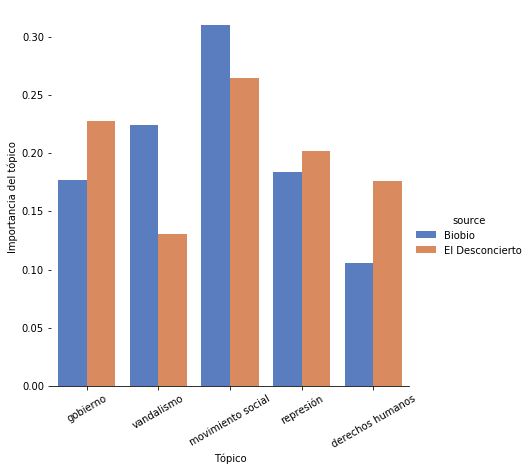

In [129]:
g = sns.catplot(x="topic", y="percentage", hue="source", data=concat_reshaped_results,
                height=6, kind="bar", palette="muted")

g.despine(left=True)
g.set_ylabels("Importancia del tópico")
g.set_xlabels("Tópico")
g.set_xticklabels(rotation=30)

#Importancia de los tópicos según fuente de información
